In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils import make_grid
from visualise import visualise_v_quiver

from configs import N_SIDE
import configs

# Import all function

In [2]:
# Import all simulation functions
from simulate import (
    simulate_detailed_convergence,
    simulate_detailed_deflection,
    simulate_detailed_curve,
    simulate_detailed_ridges,
    simulate_detailed_branching,
    simulate_detailed_edge
)

# Define simulations as a dictionary with names as keys to function objects
# Order matters
simulations = {
    "curve": simulate_detailed_curve,
    "deflection": simulate_detailed_deflection,
    "ridges": simulate_detailed_ridges,
    "branching": simulate_detailed_branching,
    "edge": simulate_detailed_edge,
}

In [3]:
#############
### TRAIN ###
#############

x_train = torch.load("data/sim_data/x_train_lines_discretised_0to1.pt", weights_only = False).float()

# Storage dictionaries
y_train_dict = {}

# Make y_train_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate training observations with sim_func
    y_train = sim_func(x_train)
    # Store training data in dictionary under sim_name
    y_train_dict[sim_name] = y_train 

############
### TEST ###
############

# Make x_grid
_, x_test = make_grid(n_side = N_SIDE)

# Storage dictionaries
y_test_dict = {}

# Make y_test_dict: Iterate over all simulation functions
for sim_name, sim_func in simulations.items():

    # Generate test observations
    y_test = sim_func(x_test)
    y_test_dict[sim_name] = y_test  # Store test outputs

    sim_mean_magnitude_for_noise = torch.norm(y_test, dim = -1).mean()
    print(f"Mean magnitude of {sim_name} for noise: {sim_mean_magnitude_for_noise:.3f}")

Mean magnitude of curve for noise: 1.572
Mean magnitude of deflection for noise: 1.470
Mean magnitude of ridges for noise: 1.478
Mean magnitude of branching for noise: 0.743
Mean magnitude of edge for noise: 0.808


(NN models first)

# dfNN

## dfNN Loss convergence

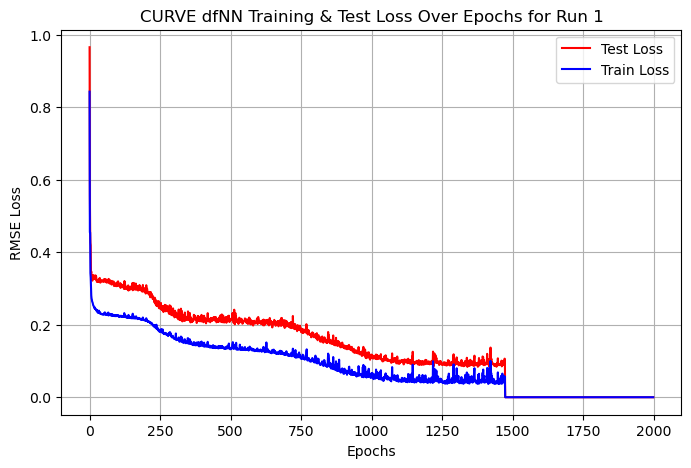

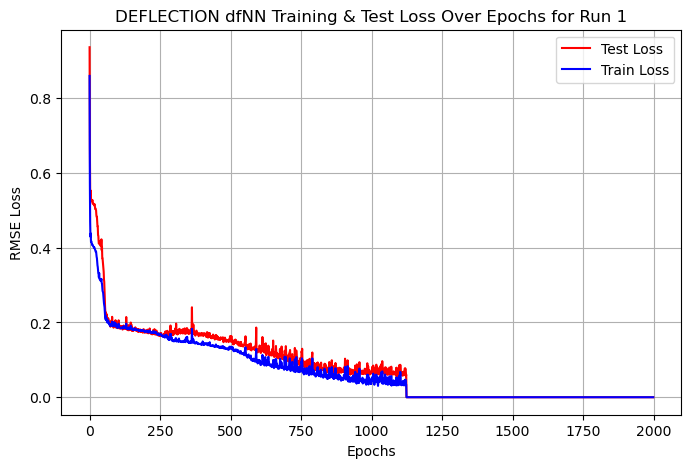

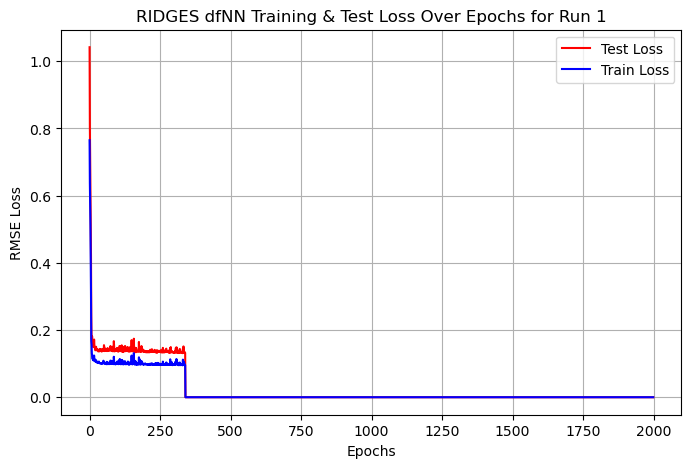

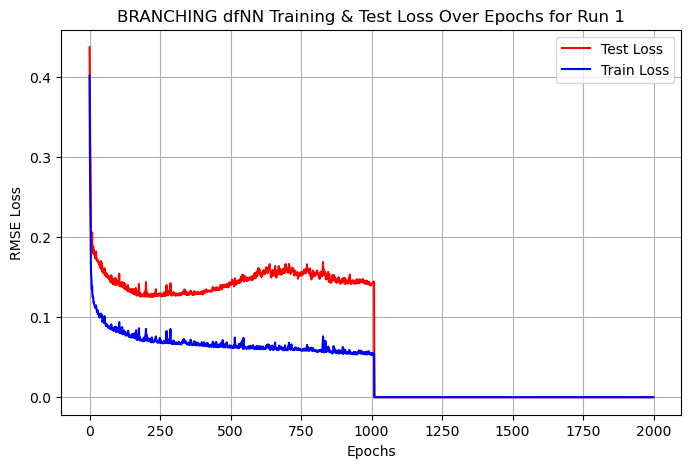

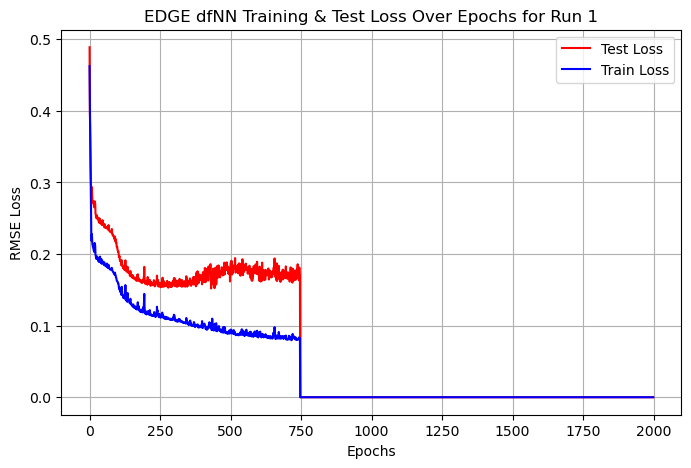

In [4]:
model_name = "dfNN"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_losses_over_epochs = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_losses_over_epochs.csv"
    losses = pd.read_csv(path_losses_over_epochs)

    plt.figure(figsize = (8, 5))
    # Test loss will likely be >> Train loss so define first
    plt.plot(losses["Epoch"], losses["Test Loss RMSE"], label = "Test Loss", color = "red")
    plt.plot(losses["Epoch"], losses["Train Loss RMSE"], label = "Train Loss", color = "blue")
    plt.xlabel("Epochs")
    plt.ylabel("RMSE Loss")
    plt.title(f"{sim_name.upper()} {model_name} Training & Test Loss Over Epochs for Run 1")
    plt.legend()
    plt.grid()
    plt.show()


## dfNN Predictions

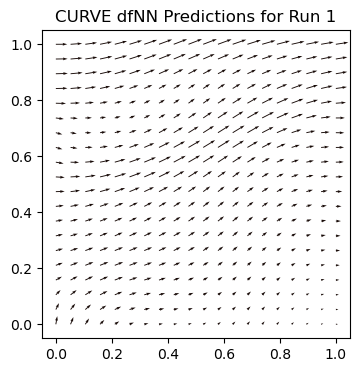

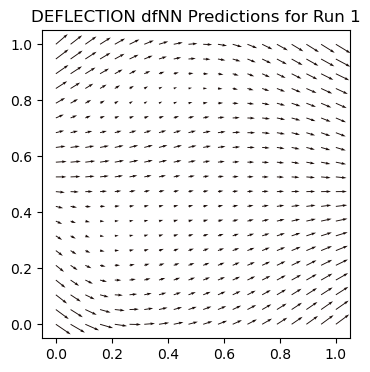

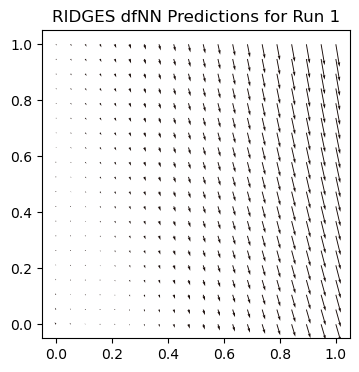

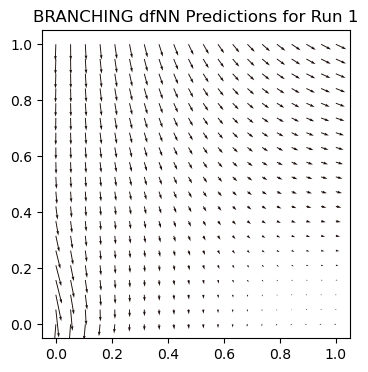

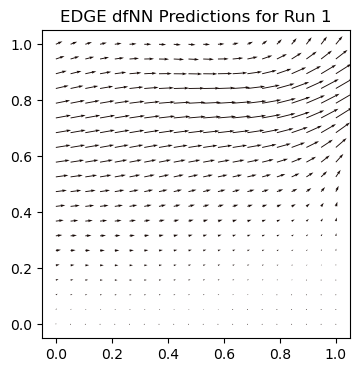

In [5]:
model_name = "dfNN"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_predictions = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_test_predictions.pt"
    # NOTE: pt
    preds = torch.load(path_predictions, weights_only = False)

    title = f"{sim_name.upper()} {model_name} Predictions for Run 1"

    visualise_v_quiver(preds, x_test, title_string = title)

# PINN

## PINN Loss convergence

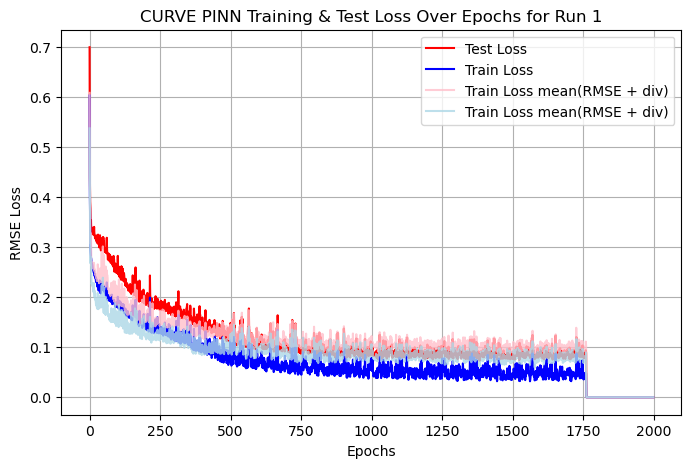

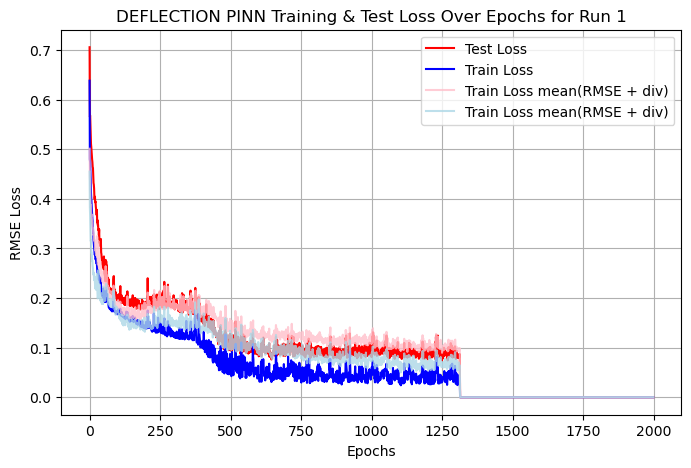

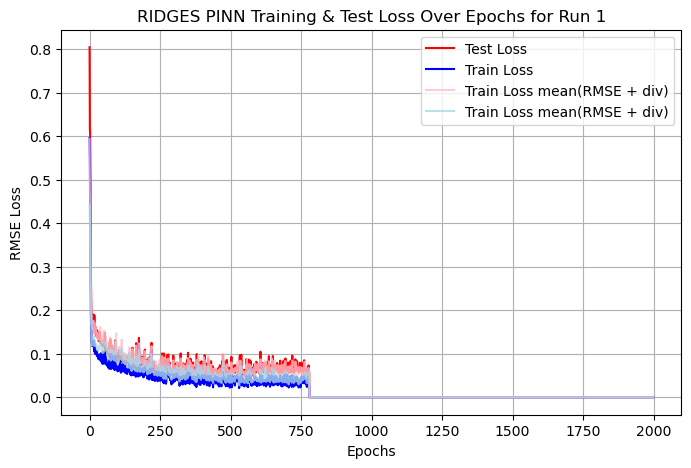

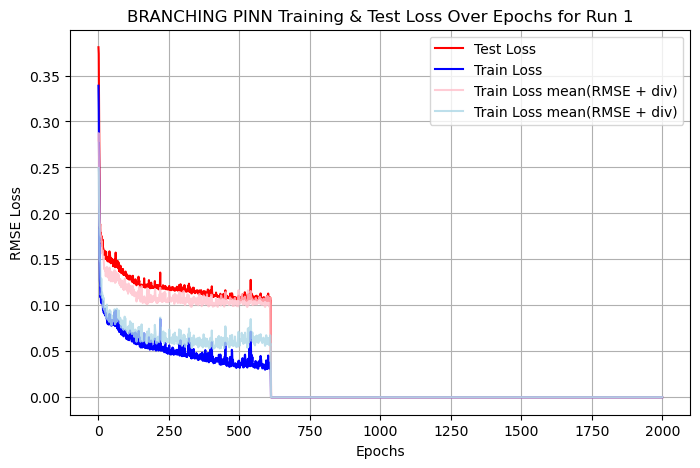

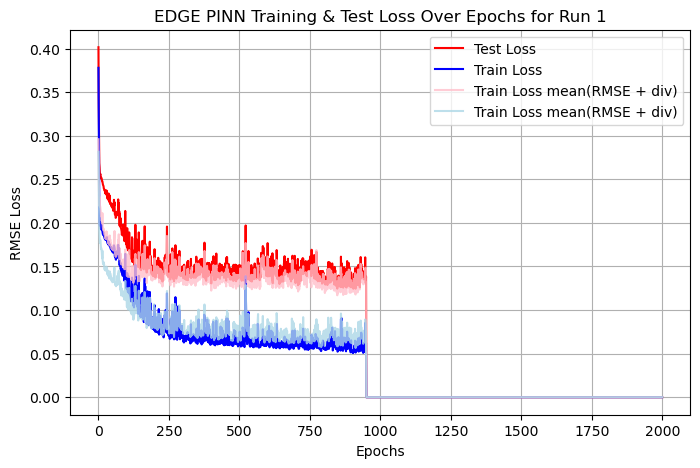

In [6]:
model_name = "PINN"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_losses_over_epochs = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_losses_over_epochs.csv"
    losses = pd.read_csv(path_losses_over_epochs)

    plt.figure(figsize = (8, 5))
    # Test loss will likely be >> Train loss so define first
    # NOTE: Plot combined loss too
    plt.plot(losses["Epoch"], losses["Test Loss RMSE"], label = "Test Loss", color = "red")
    plt.plot(losses["Epoch"], losses["Train Loss RMSE"], label = "Train Loss", color = "blue")

    plt.plot(losses["Epoch"], losses["Test Loss PINN"], label = "Train Loss mean(RMSE + div)", color = "pink", alpha = 0.8)
    plt.plot(losses["Epoch"], losses["Train Loss PINN"], label = "Train Loss mean(RMSE + div)", color = "lightblue", alpha = 0.8)
    plt.xlabel("Epochs")
    plt.ylabel("RMSE Loss")
    plt.title(f"{sim_name.upper()} {model_name} Training & Test Loss Over Epochs for Run 1")
    plt.legend()
    plt.grid()
    plt.show()

## PINN predictions

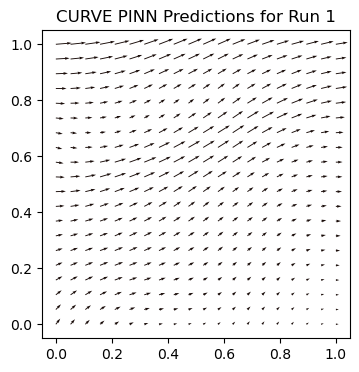

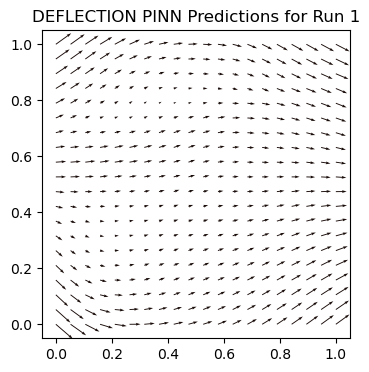

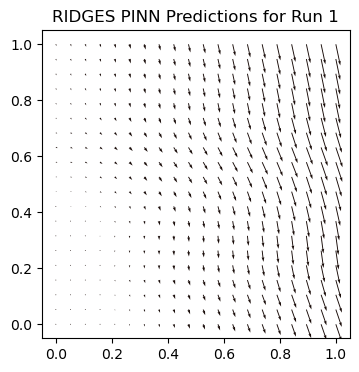

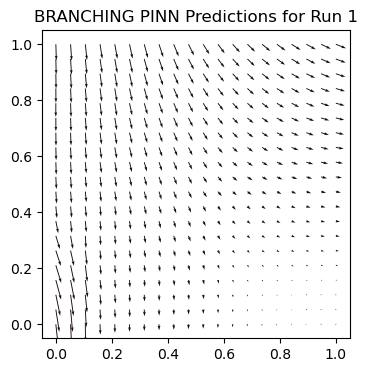

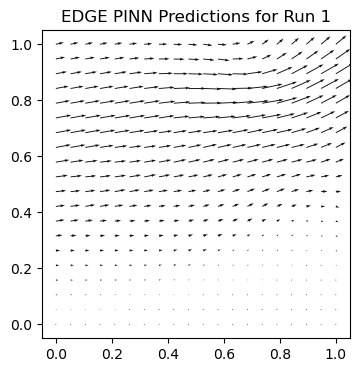

In [7]:
model_name = "PINN"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_predictions = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_test_predictions.pt"
    # NOTE: pt
    preds = torch.load(path_predictions, weights_only = False)

    title = f"{sim_name.upper()} {model_name} Predictions for Run 1"

    visualise_v_quiver(preds, x_test, title_string = title)

# dfGP

## dfGP Loss convergence

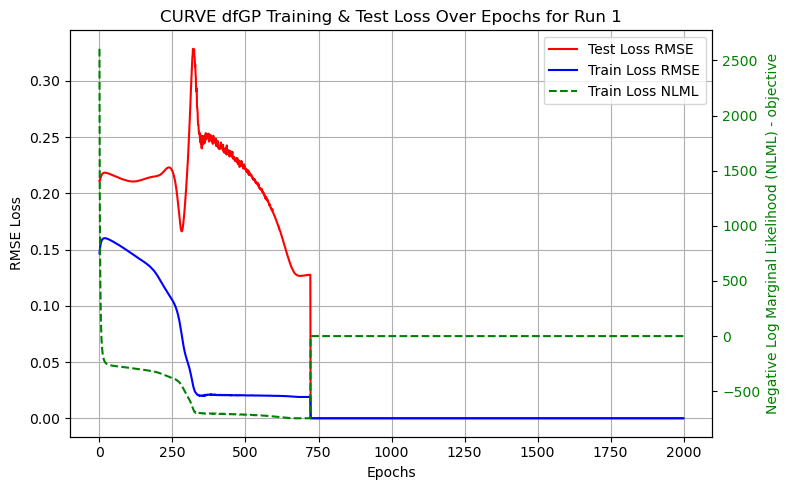

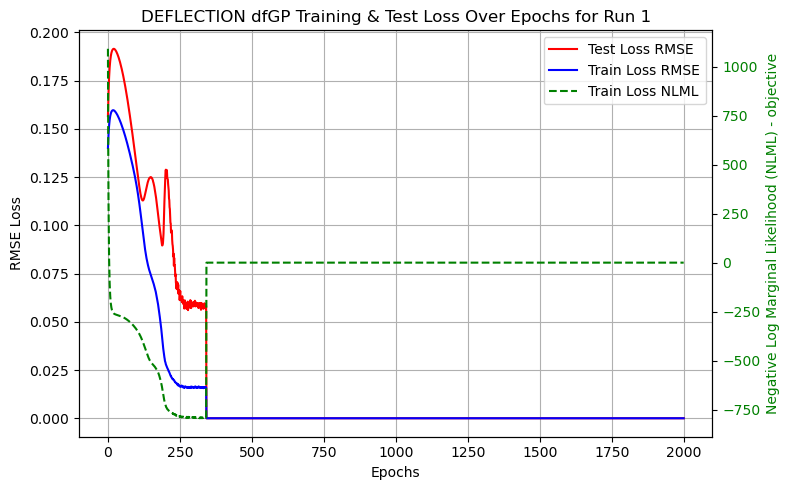

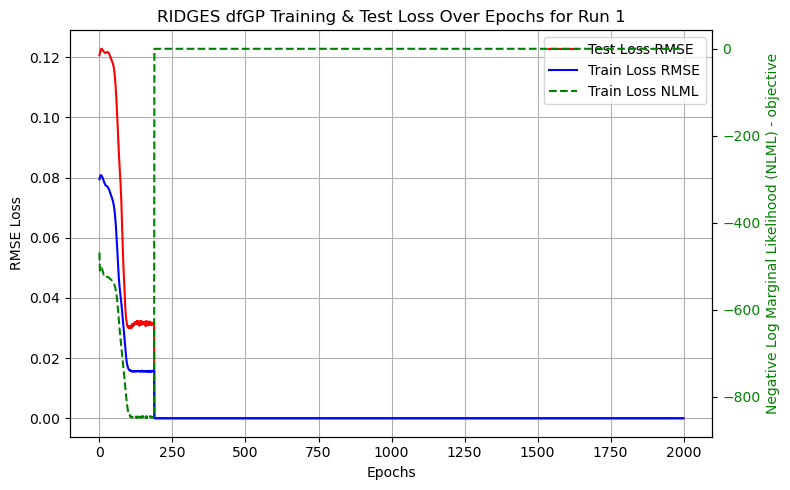

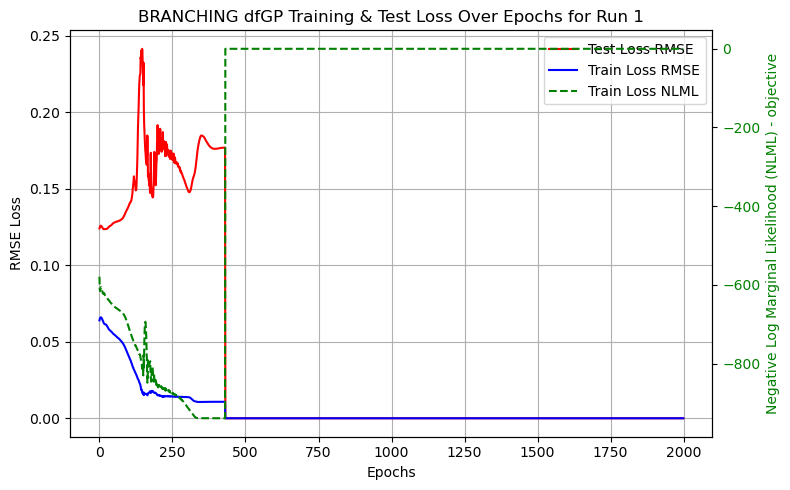

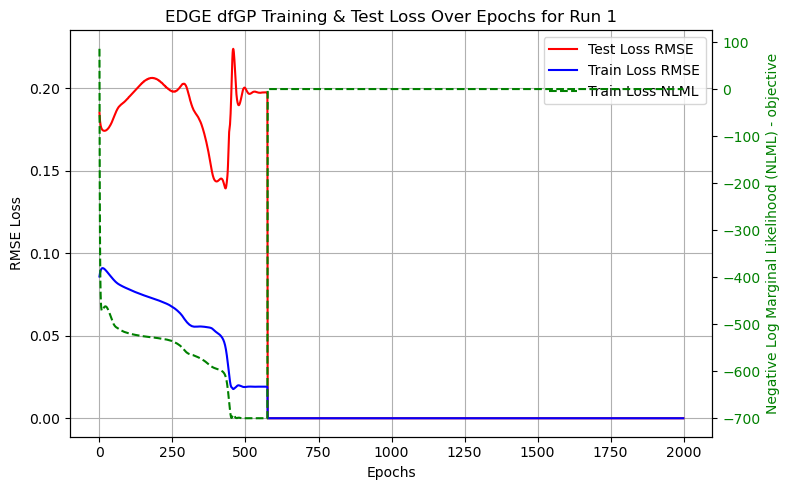

In [8]:
model_name = "dfGP"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_losses_over_epochs = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_losses_over_epochs.csv"
    losses = pd.read_csv(path_losses_over_epochs)

    fig, ax1 = plt.subplots(figsize = (8, 5))

    # Primary y-axis: RMSE
    ax1.plot(losses["Epoch"], losses["Test Loss RMSE"], label="Test Loss RMSE", color="red")
    ax1.plot(losses["Epoch"], losses["Train Loss RMSE"], label="Train Loss RMSE", color="blue")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("RMSE Loss")
    ax1.tick_params(axis = 'y', labelcolor = "black")

    # Secondary y-axis: NLML
    ax2 = ax1.twinx()
    ax2.plot(losses["Epoch"], losses["Train Loss NLML"], label = "Train Loss NLML", color = "green", linestyle = "--")
    ax2.set_ylabel("Negative Log Marginal Likelihood (NLML) - objective", color = "green")
    ax2.tick_params(axis = 'y', labelcolor = "green")

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc = "upper right")

    plt.title(f"{sim_name.upper()} {model_name} Training & Test Loss Over Epochs for Run 1")
    ax1.grid()
    plt.tight_layout()
    plt.show()

## dfGP Hyperparameter evolution

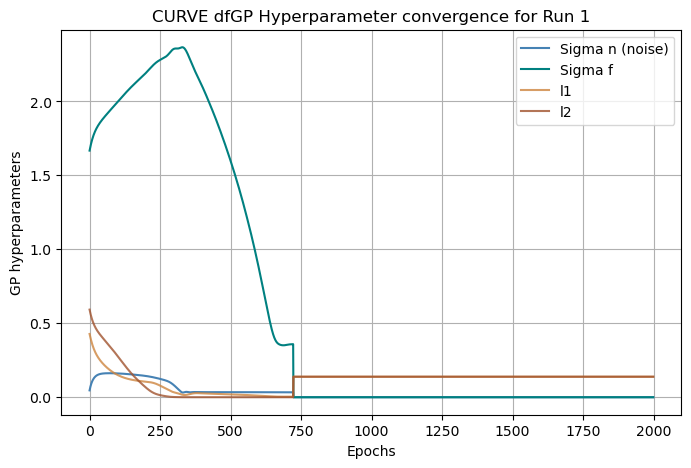

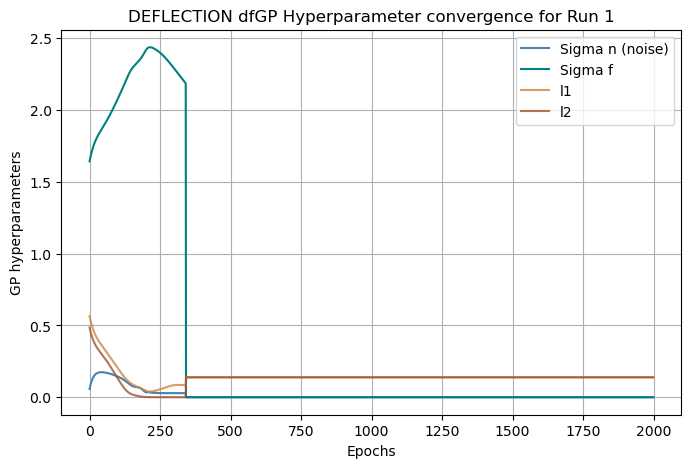

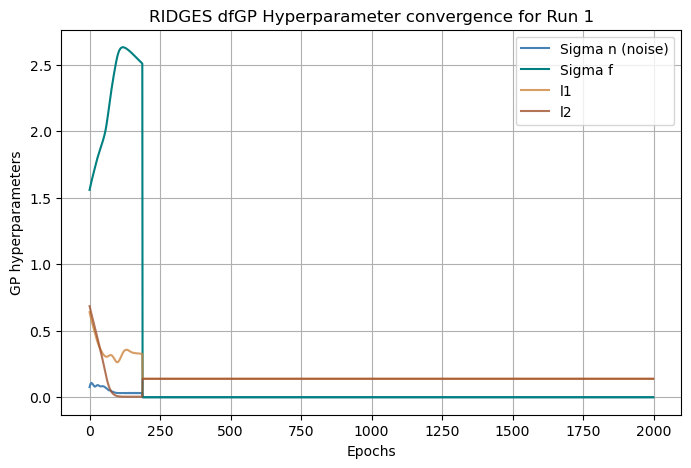

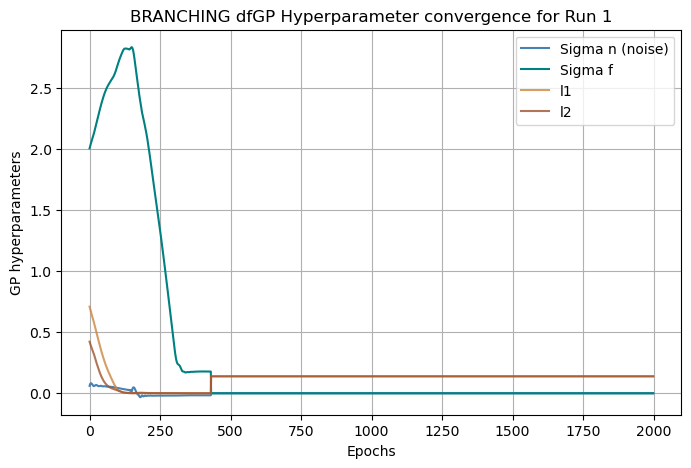

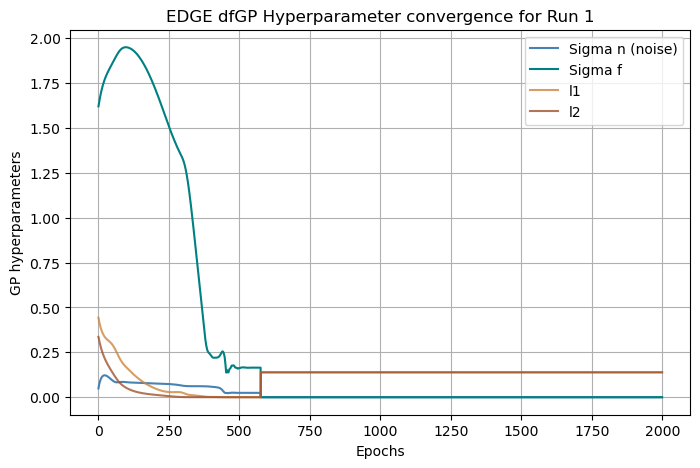

In [9]:
model_name = "dfGP"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_losses_over_epochs = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_losses_over_epochs.csv"
    losses = pd.read_csv(path_losses_over_epochs)

    plt.figure(figsize = (8, 5))
    # Test loss will likely be >> Train loss so define first
    # NOTE: Plot combined loss too
    plt.plot(losses["Epoch"], losses["Sigma_n"], label = "Sigma n (noise)", color = "steelblue")
    plt.plot(losses["Epoch"], losses["Sigma_f"], label = "Sigma f", color = "teal")

    plt.plot(losses["Epoch"], torch.nn.functional.softplus(torch.tensor(losses["l1"]), beta = 5.0) + 1e-8, label = "l1", color = "peru", alpha = 0.8)
    plt.plot(losses["Epoch"], torch.nn.functional.softplus(torch.tensor(losses["l2"]), beta = 5.0) + 1e-8, label = "l2", color = "sienna", alpha = 0.8)

    plt.xlabel("Epochs")
    plt.ylabel("GP hyperparameters")
    plt.title(f"{sim_name.upper()} {model_name} Hyperparameter convergence for Run 1")
    plt.legend()
    plt.grid()
    plt.show()

## dfGP predictions

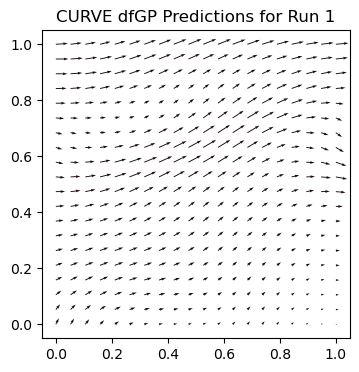

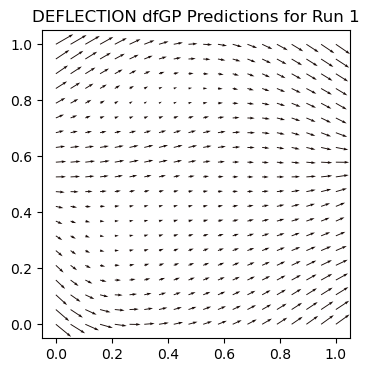

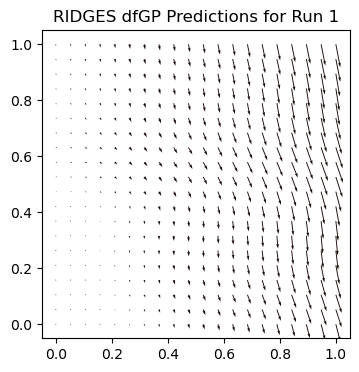

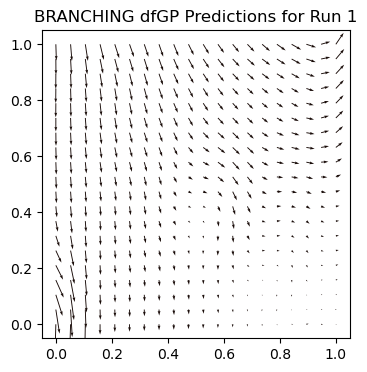

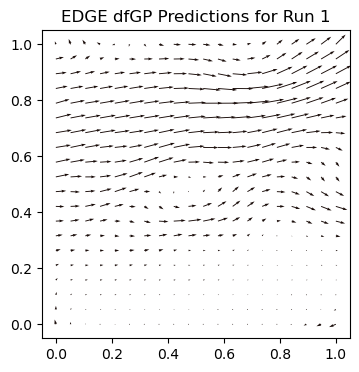

In [10]:
model_name = "dfGP"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_predictions = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_test_mean_predictions.pt"
    # NOTE: pt
    preds = torch.load(path_predictions, weights_only = False)

    title = f"{sim_name.upper()} {model_name} Predictions for Run 1"

    visualise_v_quiver(preds, x_test, title_string = title)

# GP

## GP Loss convergence

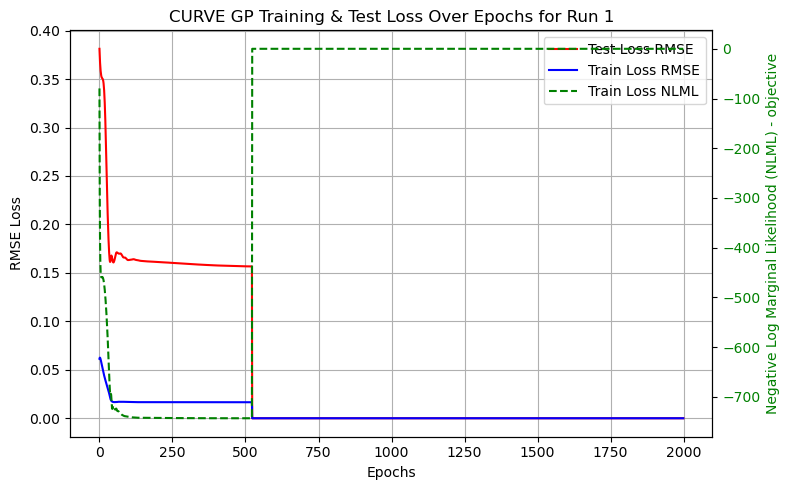

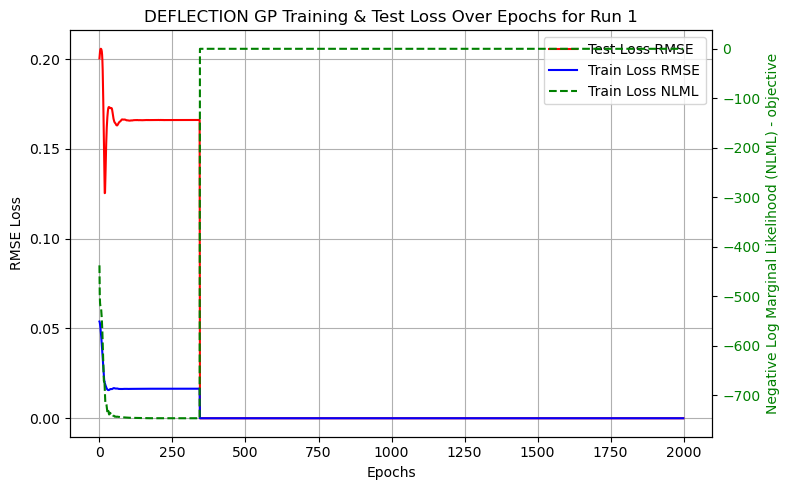

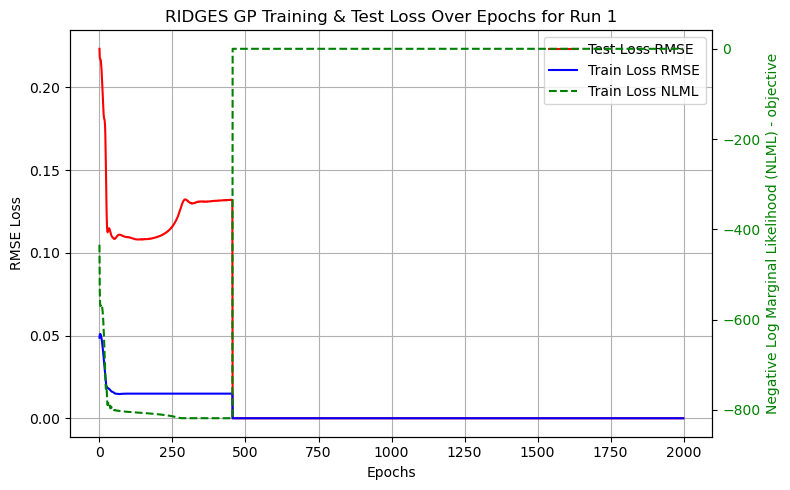

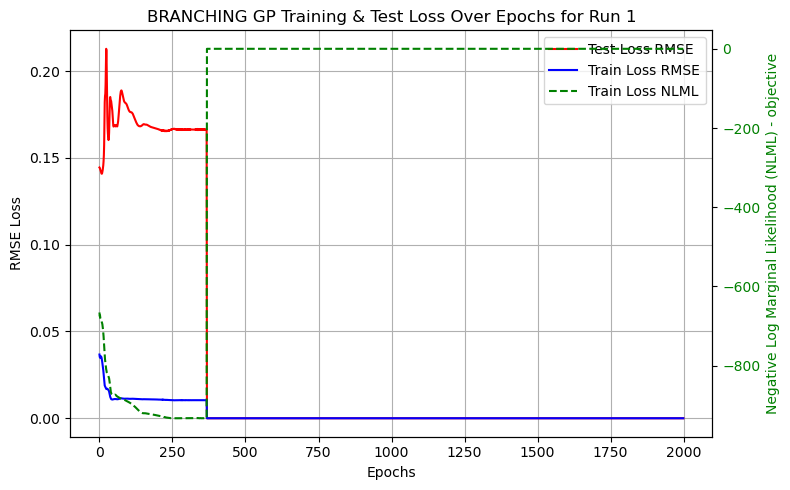

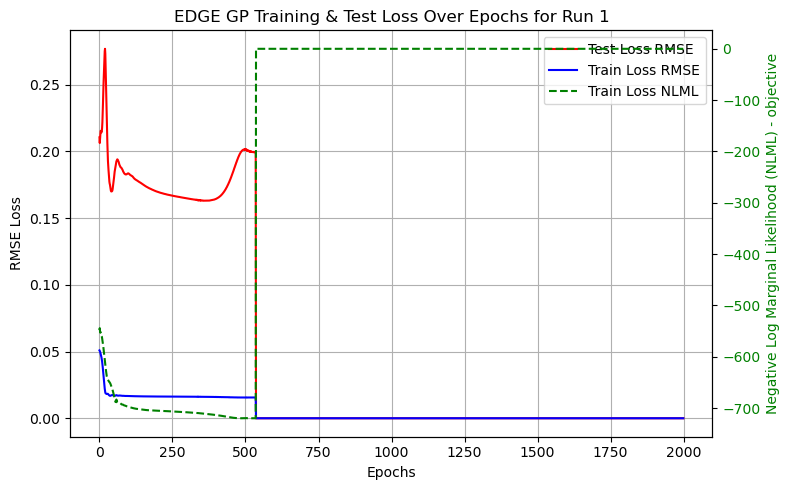

In [11]:
model_name = "GP"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_losses_over_epochs = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_losses_over_epochs.csv"
    losses = pd.read_csv(path_losses_over_epochs)

    fig, ax1 = plt.subplots(figsize = (8, 5))

    # Primary y-axis: RMSE
    ax1.plot(losses["Epoch"], losses["Test Loss RMSE"], label="Test Loss RMSE", color="red")
    ax1.plot(losses["Epoch"], losses["Train Loss RMSE"], label="Train Loss RMSE", color="blue")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("RMSE Loss")
    ax1.tick_params(axis = 'y', labelcolor = "black")

    # Secondary y-axis: NLML
    ax2 = ax1.twinx()
    ax2.plot(losses["Epoch"], losses["Train Loss NLML"], label = "Train Loss NLML", color = "green", linestyle = "--")
    ax2.set_ylabel("Negative Log Marginal Likelihood (NLML) - objective", color = "green")
    ax2.tick_params(axis = 'y', labelcolor = "green")

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc = "upper right")

    plt.title(f"{sim_name.upper()} {model_name} Training & Test Loss Over Epochs for Run 1")
    ax1.grid()
    plt.tight_layout()
    plt.show()

## GP Hyperparameter evolution

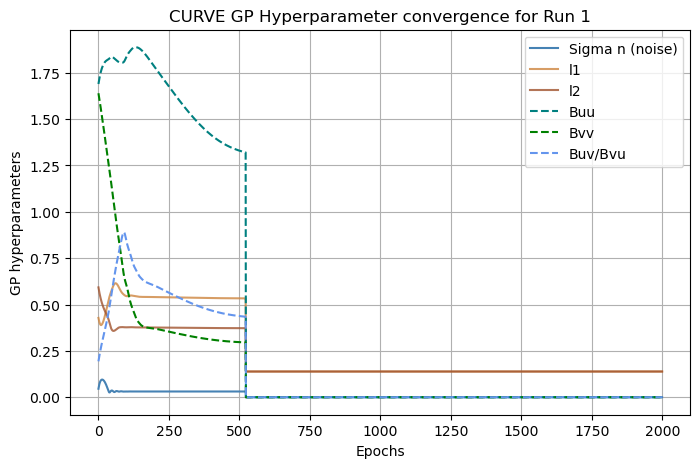

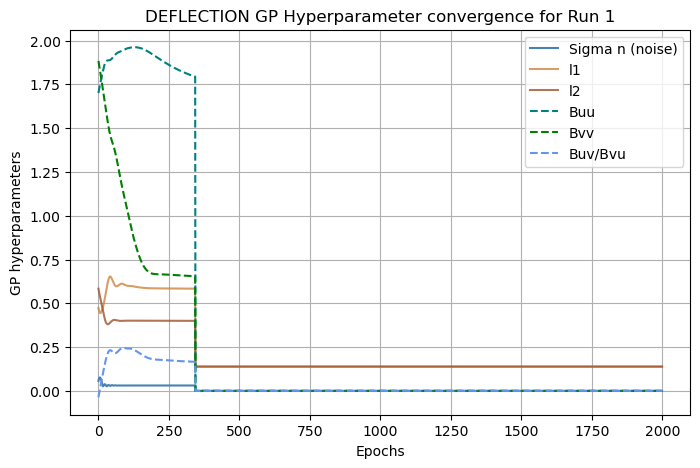

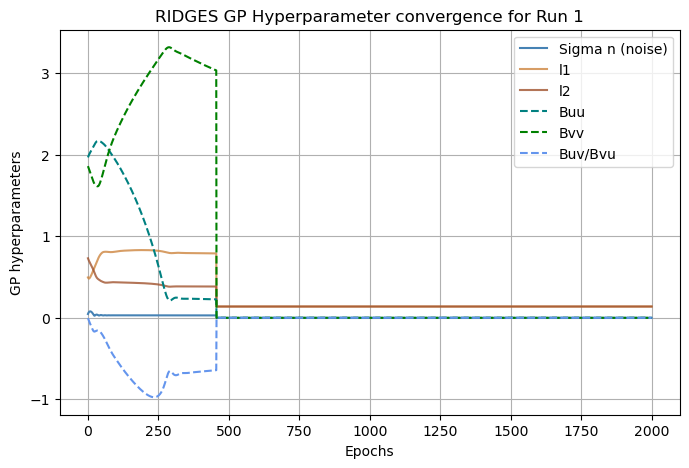

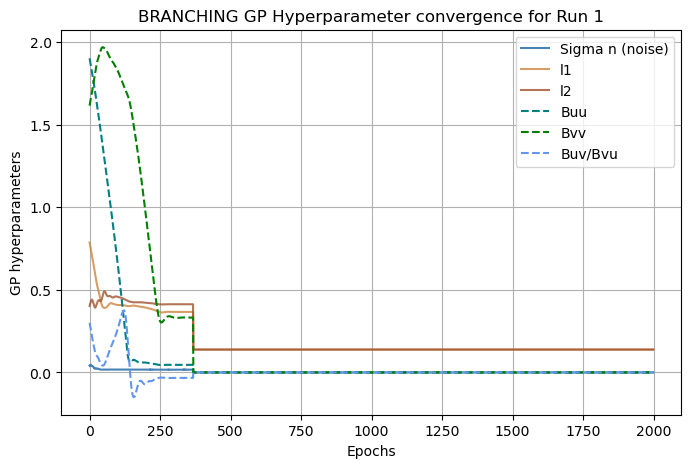

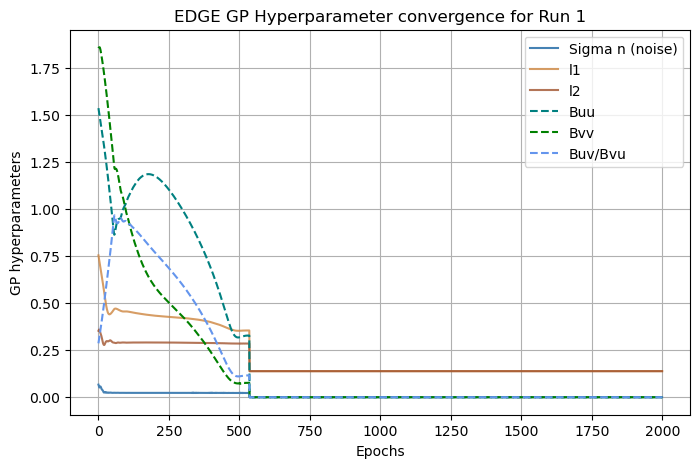

In [12]:
model_name = "GP"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_losses_over_epochs = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_losses_over_epochs.csv"
    losses = pd.read_csv(path_losses_over_epochs)

    plt.figure(figsize = (8, 5))
    # Test loss will likely be >> Train loss so define first
    # NOTE: Plot combined loss too
    plt.plot(losses["Epoch"], losses["Sigma_n"], label = "Sigma n (noise)", color = "steelblue")

    plt.plot(losses["Epoch"], torch.nn.functional.softplus(torch.tensor(losses["l1"]), beta = 5.0) + 1e-8, label = "l1", color = "peru", alpha = 0.8)
    plt.plot(losses["Epoch"], torch.nn.functional.softplus(torch.tensor(losses["l2"]), beta = 5.0) + 1e-8, label = "l2", color = "sienna", alpha = 0.8)

    plt.plot(losses["Epoch"], losses["Buu"], label = "Buu", color = "teal", linestyle = "--")
    plt.plot(losses["Epoch"], losses["Bvv"], label = "Bvv", color = "green", linestyle = "--")
    plt.plot(losses["Epoch"], losses["Buv"], label = "Buv/Bvu", color = "cornflowerblue", linestyle = "--")

    plt.xlabel("Epochs")
    plt.ylabel("GP hyperparameters")
    plt.title(f"{sim_name.upper()} {model_name} Hyperparameter convergence for Run 1")
    plt.legend()
    plt.grid()

## GP predictions

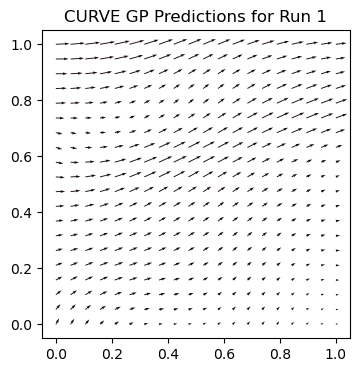

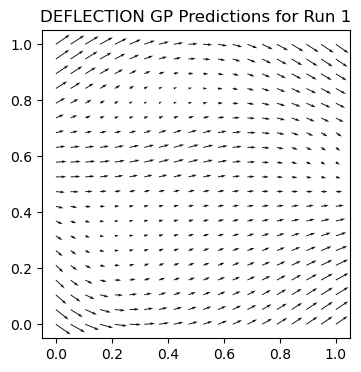

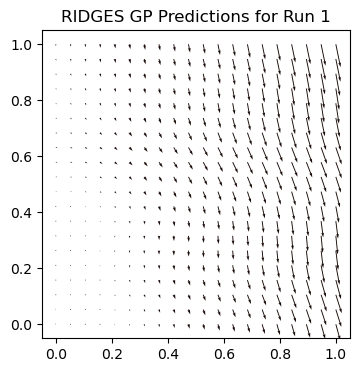

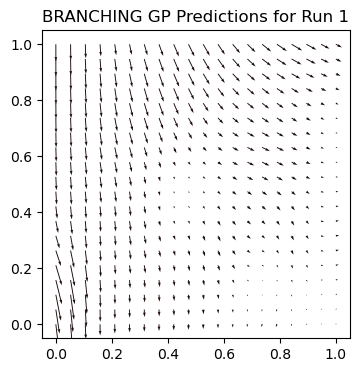

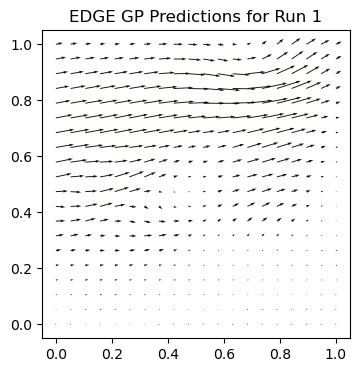

In [13]:
model_name = "GP"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_predictions = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_test_mean_predictions.pt"
    # NOTE: pt
    preds = torch.load(path_predictions, weights_only = False)

    title = f"{sim_name.upper()} {model_name} Predictions for Run 1"

    visualise_v_quiver(preds, x_test, title_string = title)

# dfNGP

## dfNGP Loss convergence

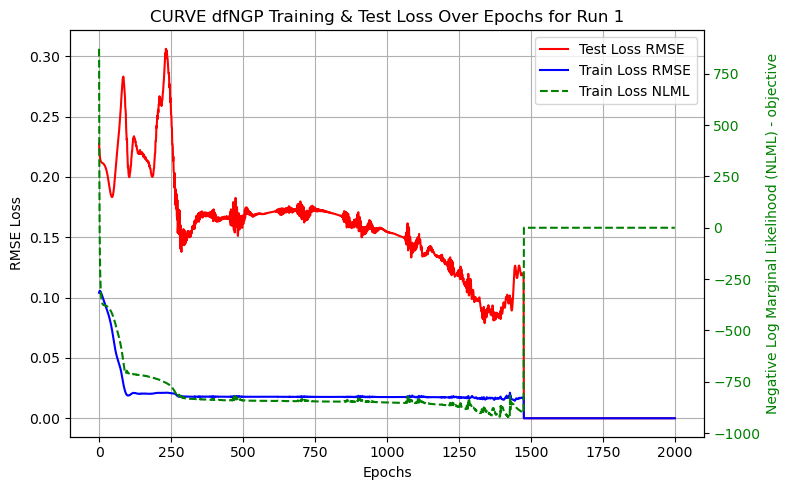

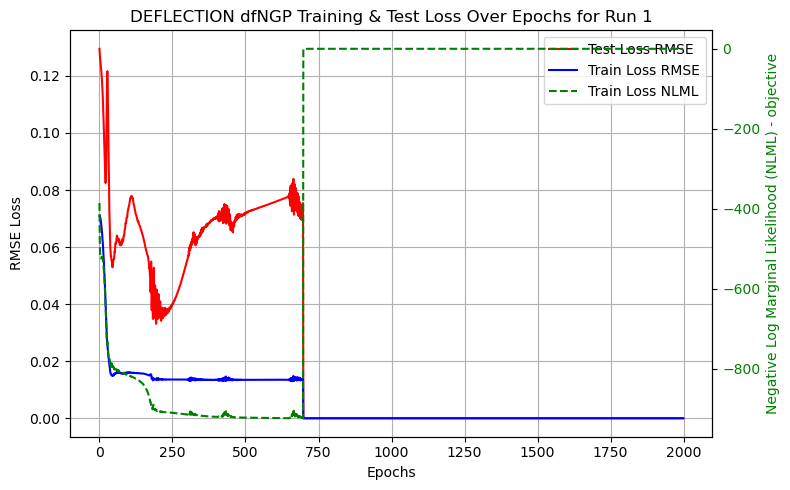

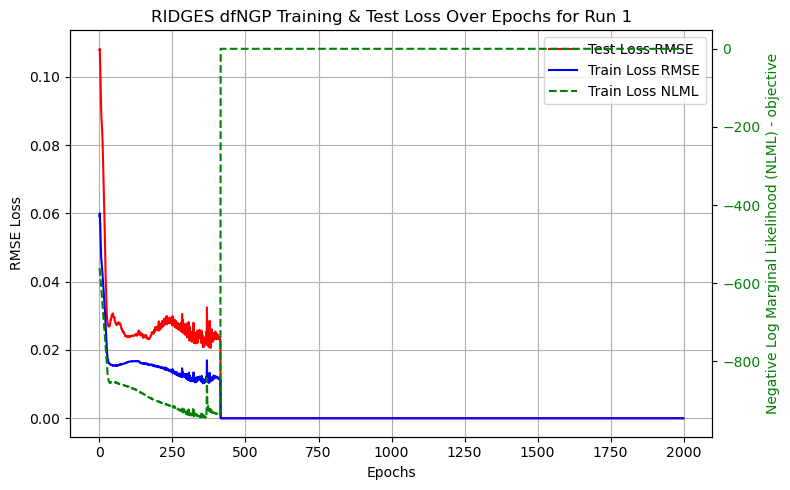

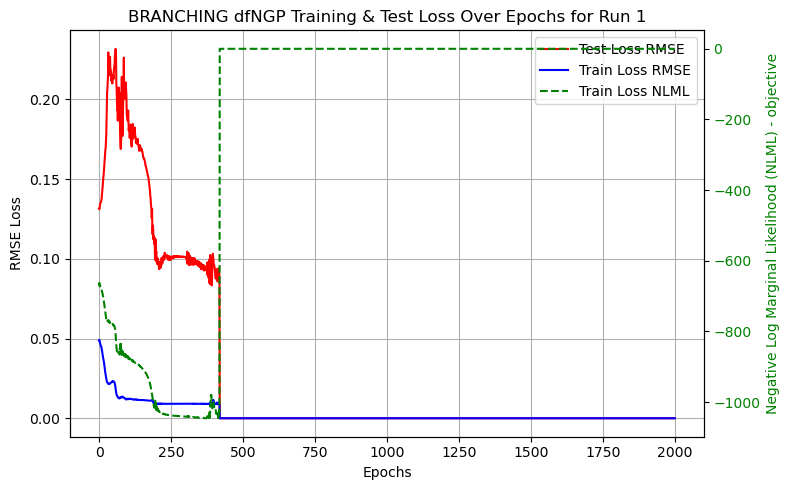

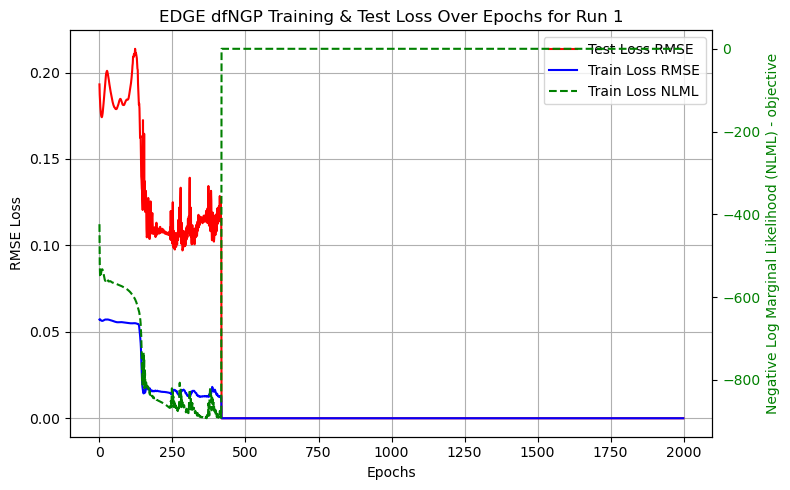

In [14]:
model_name = "dfNGP"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_losses_over_epochs = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_losses_over_epochs.csv"
    losses = pd.read_csv(path_losses_over_epochs)

    fig, ax1 = plt.subplots(figsize = (8, 5))

    # Primary y-axis: RMSE
    ax1.plot(losses["Epoch"], losses["Test Loss RMSE"], label="Test Loss RMSE", color="red")
    ax1.plot(losses["Epoch"], losses["Train Loss RMSE"], label="Train Loss RMSE", color="blue")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("RMSE Loss")
    ax1.tick_params(axis = 'y', labelcolor = "black")

    # Secondary y-axis: NLML
    ax2 = ax1.twinx()
    ax2.plot(losses["Epoch"], losses["Train Loss NLML"], label = "Train Loss NLML", color = "green", linestyle = "--")
    ax2.set_ylabel("Negative Log Marginal Likelihood (NLML) - objective", color = "green")
    ax2.tick_params(axis = 'y', labelcolor = "green")

    # Combine legends
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines + lines2, labels + labels2, loc = "upper right")

    plt.title(f"{sim_name.upper()} {model_name} Training & Test Loss Over Epochs for Run 1")
    ax1.grid()
    plt.tight_layout()
    plt.show()

## dfNGP Hyperparameter evolution

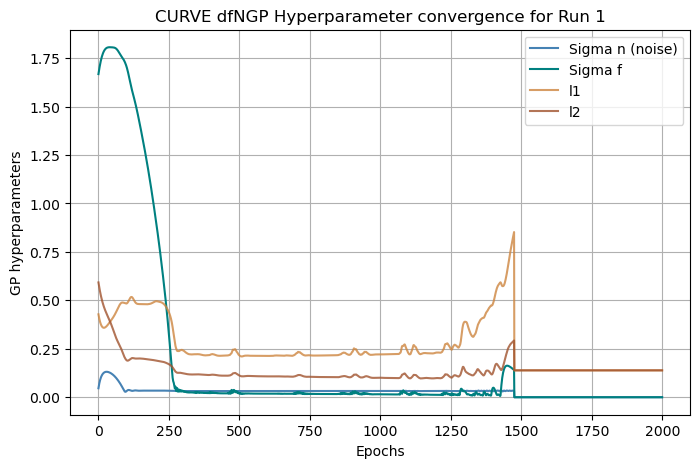

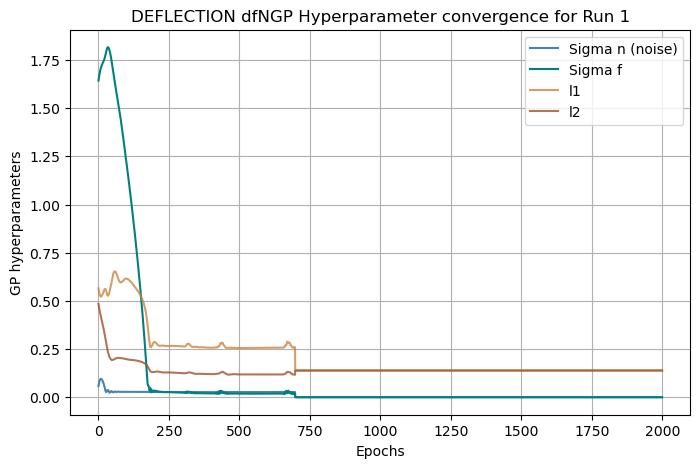

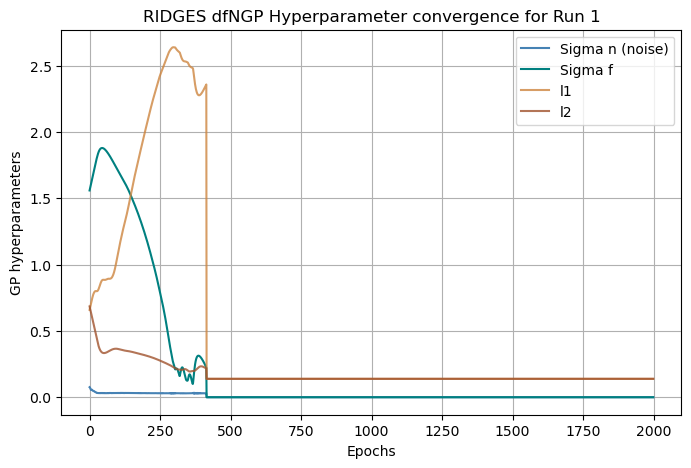

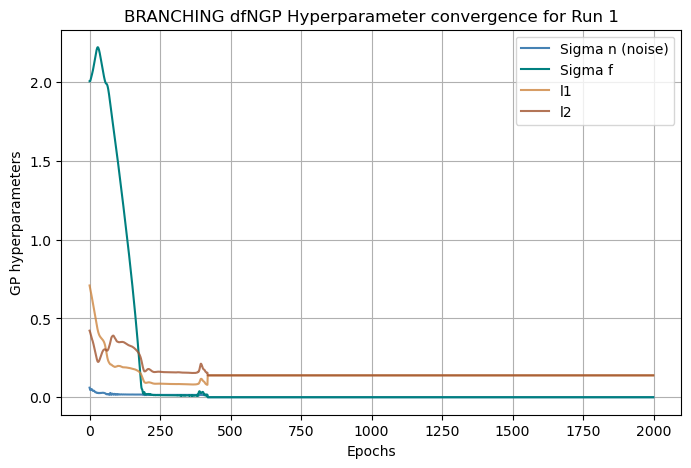

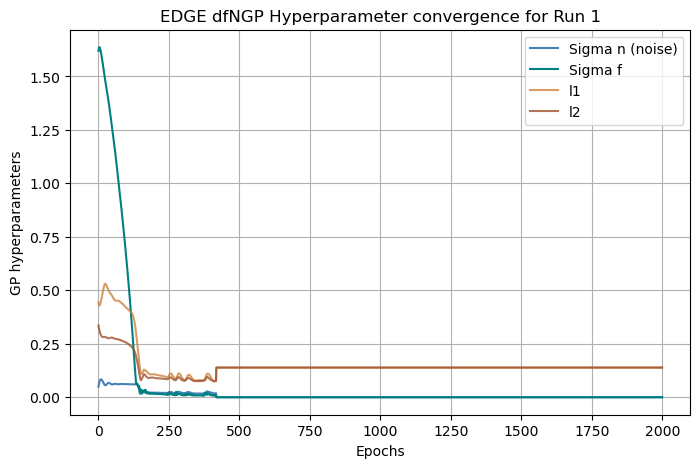

In [15]:
model_name = "dfNGP"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_losses_over_epochs = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_losses_over_epochs.csv"
    losses = pd.read_csv(path_losses_over_epochs)

    plt.figure(figsize = (8, 5))
    # Test loss will likely be >> Train loss so define first
    # NOTE: Plot combined loss too
    plt.plot(losses["Epoch"], losses["Sigma_n"], label = "Sigma n (noise)", color = "steelblue")
    plt.plot(losses["Epoch"], losses["Sigma_f"], label = "Sigma f", color = "teal")

    plt.plot(losses["Epoch"], torch.nn.functional.softplus(torch.tensor(losses["l1"]), beta = 5.0) + 1e-8, label = "l1", color = "peru", alpha = 0.8)
    plt.plot(losses["Epoch"], torch.nn.functional.softplus(torch.tensor(losses["l2"]), beta = 5.0) + 1e-8, label = "l2", color = "sienna", alpha = 0.8)

    plt.xlabel("Epochs")
    plt.ylabel("GP hyperparameters")
    plt.title(f"{sim_name.upper()} {model_name} Hyperparameter convergence for Run 1")
    plt.legend()
    plt.grid()
    plt.show()

# some weight decay on the params would probably actually be good.

## dfNGP predictions

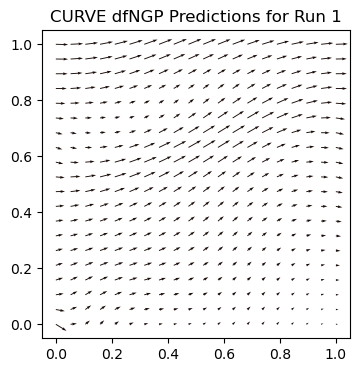

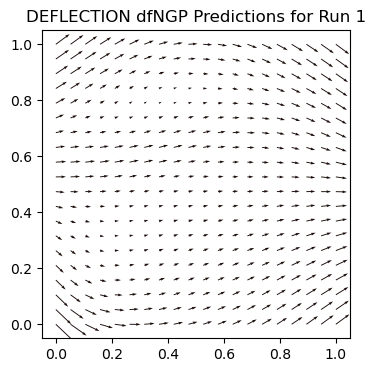

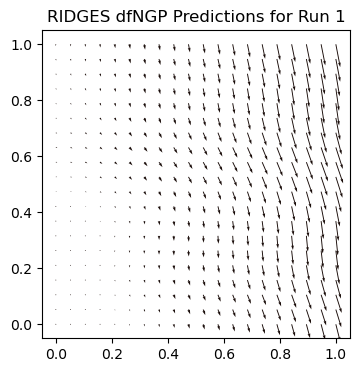

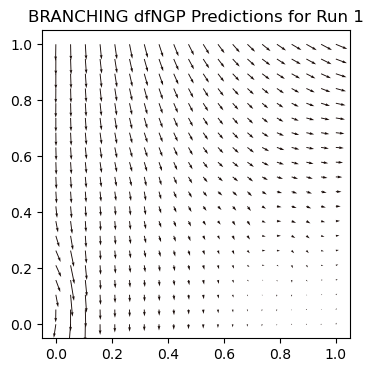

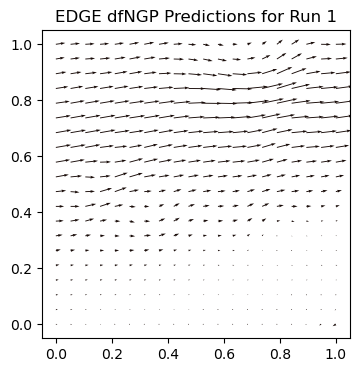

In [16]:
model_name = "dfNGP"
MODEL_SIM_RESULTS_DIR = getattr(configs, f"{model_name}_SIM_RESULTS_DIR")

for sim_name, _ in simulations.items():
    path_predictions = MODEL_SIM_RESULTS_DIR + "/" + sim_name + "_" + model_name + "_test_mean_predictions.pt"
    # NOTE: pt
    preds = torch.load(path_predictions, weights_only = False)

    title = f"{sim_name.upper()} {model_name} Predictions for Run 1"

    visualise_v_quiver(preds, x_test, title_string = title)